# imports & settings

In [1]:
import numpy as np
import pandas as pd
%precision %.3f

from glob import glob
from tqdm import tqdm

from os.path import join
import ntpath 
from copy import deepcopy
import pytz
TZ = pytz.FixedOffset(540) # GMT+09:00; Asia/Seoulsilent


%load_ext autoreload
%autoreload 2
import sys  
sys.path.insert(0, '../') # to import from parent directory
import utils
from utils import *
import recept_dataset
from f_preprocessing import impute_support_features, impute, normalization

from sklearn import metrics 
from sklearn.model_selection import StratifiedKFold, GroupKFold

import warnings
from functools import reduce
from itertools import product

import matplotlib
matplotlib.rc('font', size=22)
from matplotlib import pyplot as plt

In [2]:
RANDOM_STATE=utils.RANDOM_STATE
DATAROOT = utils.DATAROOT
BALANCED_TRAINING = True
ALREADY_EXTRACTED_SUBFEATURES = True

## Function definitions for classification experiment

### metrics

In [3]:
def perf_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    y_pred_cls = np.rint(y_pred)    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        acc = metrics.accuracy_score(y_true, y_pred_cls)
        acc_bal = metrics.balanced_accuracy_score(y_true, y_pred_cls)
        f1_score = metrics.f1_score(
            y_true=y_true, y_pred=y_pred_cls,average='binary',pos_label=1
        )
        auc = metrics.roc_auc_score(
            y_true=y_true, y_score=y_pred, average='macro'
        )
    return dict(
        ACC=acc*100, ACC_BAL=acc_bal*100, F1_score = f1_score*100
        , AUC=auc
    )


### classifiers

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import xgboost as xgb
import catboost

classifiers = {
    'lr':LogisticRegression(random_state = RANDOM_STATE, max_iter=500 ),
    'lr_lasso_C=0.1':LogisticRegression(
        penalty='l1', solver='saga' ,random_state = RANDOM_STATE
        , max_iter=500, C=0.1
    ),
    'lr_lasso_C=0.01':LogisticRegression(
        penalty='l1', solver='saga' ,random_state = RANDOM_STATE
        , max_iter=500, C=0.01
    ),
    'lr_lasso_C=0.1_maxiter=1000':LogisticRegression(
        penalty='l1', solver='saga'
        ,random_state = RANDOM_STATE, max_iter=1000
        , C=0.1
    ),
    'knn':KNeighborsClassifier(),
    'svm':SVC(probability=True),
    'gp':GaussianProcessClassifier(),
    'dt':DecisionTreeClassifier(random_state = RANDOM_STATE),
    'rf':RandomForestClassifier(random_state = RANDOM_STATE),
    'mlp':MLPClassifier(),
    'adaboost':AdaBoostClassifier(),
    'gnb':GaussianNB(),
    'qda':QuadraticDiscriminantAnalysis(),
    'catboost': catboost.CatBoostClassifier(
        random_seed=RANDOM_STATE, eval_metric='AUC'
    )    
    #,'xgboost':xgb.Booster()
    }



classifier_names = {
    'lr':'LogisticRegression'
    ,'lr_lasso_C=0.1':'lr_lasso_C=0.1'
    ,'lr_lasso_C=0.01':'lr_lasso_C=0.01'
    ,'lr_lasso_C=0.1_maxiter=1000':'lr_lasso_C=0.1_maxiter=1000'
    ,'knn':'KNeighborsClassifier',
    'svm':'SVM',
    'gp':'GaussianProcess',
    'dt':'DecisionTree',
    'rf':'RandomForest',
    'mlp':'Multi-layer Perceptron',
    'adaboost':'AdaBoost',
    'gnb':'Gaussian Naive Bayes',
    'qda':'QuadraticDiscriminantAnalysis',
    'catboost':'CatBoost'
    #,'xgboost':'XGBoost'
}

### run_classification

In [5]:
def run_classification(
    df, use_ray = True,  cat_features=None, classifier_name='catboost',
    feature_selection = None, experiment_name=''
) :   
    y = df['receptivity'].replace({
        'receptive':1,'non-receptive':0
    })
    X = df.drop(columns='receptivity')
    pids = df.index.get_level_values('pid')

    results = LOGO_5fold(
        X,y, pids, feature_selection=feature_selection,
        cat_features=cat_features,
        classifier_name=classifier_name
        ,use_ray=use_ray
    )
    
    results.insert(results.shape[1], 'experiment',experiment_name)
    return results
    


### CV

In [6]:
def LOGO_5fold(
    X,y, pids, cat_features=None, classifier_name='catboost',
    feature_selection = None
    , use_ray=False
):
    func = ray.remote(run_trial).remote if use_ray else run_trial
    results = []    
    for train_index, test_index in tqdm(
        GroupKFold(n_splits=5).split(X, y, groups=pids)
    ):        
        res = func(
            X,y, train_index,test_index,
            cat_features=cat_features, classifier_name=classifier_name,
            feature_selection = feature_selection
        )
        results.append(res) 
    results = ray.get(results) if use_ray else results
    results = pd.DataFrame(results)
    results.insert(results.shape[1],'CV_TYPE','LOGO_5fold')
    return results


### run trial

In [7]:
def run_trial(X, y,  train_index,test_index,             
              feature_selection = None, cat_features=None, 
              classifier_name='catboost'):

    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    if BALANCED_TRAINING:
        X_train, y_train = balance_data(X_train, y_train)
        
    if feature_selection['status']:
        X_train = select_features(X_train, y_train, feature_selection)
        
    clf = classifiers[classifier_name]
    feature_names =X_train.columns.tolist()

    if classifier_name=='catboost':
        d_train = catboost.Pool(
            data = X_train,
            label = y_train,
            feature_names = feature_names,
            cat_features = cat_features
        )
        
        clf.fit(X = d_train, verbose_eval=False, early_stopping_rounds=20)
    else:
        clf.fit(X_train, y_train)
        
    prob = clf.predict_proba(X.iloc[test_index][feature_names])[:,1]
    test_metrics = perf_metrics(y.iloc[test_index], prob)    

    prob = clf.predict_proba(X.iloc[train_index][feature_names])[:,1]
    train_metrics = perf_metrics(y.iloc[train_index], prob)

    res = {f'TEST_{k}':v  for k,v in test_metrics.items()}
    res.update({f'TRAIN_{k}':v  for k,v in train_metrics.items()})
    return res    

### balance data

In [8]:
from imblearn.over_sampling import RandomOverSampler
def balance_data(X_train, y_train):
    ros = RandomOverSampler(random_state=RANDOM_STATE)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    return X_train, y_train
    

### feature selection

In [9]:
from sklearn.linear_model import  Lasso
def select_features(X_train, y_train, feature_selection):
    if feature_selection['method']=='LASSO':
        classifier = Lasso(tol=1e-3)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            classifier.fit(X=X_train, y=y_train)
        coef=np.abs(classifier.coef_)
        I = coef.argsort()
        keep_ratio=feature_selection['keep_ratio']
        num_features_to_keep = int(keep_ratio*X_train.shape[1])            

        X_train =  X_train[X_train.columns[I[-1*num_features_to_keep:]]]
        return X_train
        

# Data Split

In [12]:

LABEL_DTYPES = {
            'valence':float
            ,'arousal': float
            ,'attention': float
            ,'stress': float
            ,'duration': float
            ,'change': float
            , 'pid':str            
        }
labels = pd.read_csv(
    join(DATAROOT,'binned_esm_data.csv'), 
    dtype=LABEL_DTYPES,
    parse_dates=['timestamp']
).set_index(['pid','timestamp'])

pids = labels.index.get_level_values('pid').unique().tolist()
N = len(pids)
r = .5 # rule mining pariticpants ratio
arm_pids = pids[:int(N*r)]

labels_arm = labels[labels.index.get_level_values('pid').isin(arm_pids)]
labels_ml = labels[~labels.index.get_level_values('pid').isin(arm_pids)]
labels_arm.shape, labels_ml.shape
print("arm_pids",len(np.unique(arm_pids)),'ml_pids'
      , len(np.unique(pids))-len(np.unique(arm_pids)))

arm_pids 36 ml_pids 37


In [13]:
labels_arm.shape, labels_ml.shape

((1580, 20), (1754, 20))

# RuleGenerateSet


In [14]:
labels_arm.receptivity.value_counts()

receptive        913
non-receptive    667
Name: receptivity, dtype: int64

In [15]:
labels_ml.receptivity.value_counts()

receptive        1025
non-receptive     729
Name: receptivity, dtype: int64

In [16]:

num_participants = labels_arm.index.get_level_values('pid').nunique()


sub_winsize = 20 # min
print('number of sub-windows (transactions) for the given feature:\n num_participants*days_of_collection*collection_hours*MIN_IN_HOUR/sub_winsize')
num_participants*utils.COLLECTION_DAYS*utils.COLLECTION_HOURS*utils.MIN_IN_HOUR//sub_winsize

number of sub-windows (transactions) for the given feature:
 num_participants*days_of_collection*collection_hours*MIN_IN_HOUR/sub_winsize


9072

### Select window size
- which window size
    - 40  MIN
    - 80  MIN
    

- how many sub window size
    - 2
    - 4
    - 8

In [14]:
windows = [40,80,160]
num_sub_windows = [2,4,8]


#### Extract sub features

In [ ]:
from itertools import product

with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=40):    
    for nsub, window_size_in_min in product(num_sub_windows,windows):
        print(f'{window_size_in_min}MIN at {nsub} subwindows')
        sub_features = recept_dataset.parallellize_extract_sub(
            labels=labels_arm
            , w_size_in_min = window_size_in_min
            ,num_sub=nsub
        )
        sub_features.to_csv(
            f'feature/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv')

#### find missing features per combination

In [15]:
measurement = pd.DataFrame( columns=[
    'number of subwindows','window size','percentage of missing features'
])

for nsub, window_size_in_min in product(num_sub_windows,windows):
    sub_features = pd.read_csv(
        f'feature/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv'
    ).set_index(['pid','timestamp','sub_timestamp']) 
    sub_features = impute_support_features(sub_features)
    ds = sub_features.isnull().sum(axis=0)  
    ds = ds.sort_values(ascending=True).values/sub_features.shape[1]
    ds = ds/(len(sub_features))
    
    measurement = pd.concat(
        [
            measurement
            ,pd.DataFrame({
                'number of subwindows':[nsub]
                ,'window size':[window_size_in_min]
                ,'percentage of missing features':[ds.sum()*100]
            })
        ]
        , ignore_index=True
    )

pd.set_option("display.precision", 2)

measurement = measurement.set_index(['number of subwindows','window size'])
measurement = measurement.sort_index()
measurement.to_csv(f'setting/missing_feature_for_each_combinations.csv')
measurement

percentage of missing features
number of subwindows window size                                
2                    40                                     3.34
                     80                                     3.18
                     160                                    3.23
4                    40                                     3.64
                     80                                     3.58
                     160                                    3.82
8                    40                                     3.91
                     80                                     3.88
                     160                                    4.25

### aggregated features 
#### compute

In [16]:
EXTRACTED_AGGRAGETED = False

def read_sub_features(window_size_in_min=80, nsub=4):
    sub_features = pd.read_csv(
        f'feature/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv'
        ,dtype={'pid':str}
        ,parse_dates=['timestamp','sub_timestamp']
    ).set_index(['pid','timestamp','sub_timestamp'])
    return sub_features


def extract_aggregated_features(window_size_in_min=80, nsub=4):
    sub_features = read_sub_features(window_size_in_min, nsub)
    sub_features_preprocessed = impute_support_features(
            normalization(sub_features)
    )

    agg_feature = sub_features_preprocessed.groupby(
        ['pid','timestamp']
    ).agg(['mean','std'])
    agg_feature.columns = agg_feature.columns.map('|'.join).str.strip('|')
    agg_feature.to_csv(
        f'feature/arm/agg_feature_{window_size_in_min}MIN_{nsub}.csv'
    )

In [17]:
import recept_dataset 
window_size_in_min, nsub = 80, 4 # selected above

if not EXTRACTED_AGGRAGETED:
    extract_aggregated_features()
    
agg_feature = pd.read_csv(
    f'feature/arm/agg_feature_{window_size_in_min}MIN_{nsub}.csv'
    ,dtype={'pid':str}
    ,parse_dates=['timestamp']
).set_index(['pid','timestamp'])
agg_feature

appUsage_appPackage#ETP|mean  \
pid  timestamp                                           
1501 2019-05-16 12:17:02                          0.12   
     2019-05-16 13:46:27                          0.20   
     2019-05-16 14:28:19                          0.15   
     2019-05-16 15:12:59                          0.22   
     2019-05-16 16:41:48                          0.34   
...                                                ...   
729  2019-05-14 18:10:13                          0.50   
     2019-05-14 18:54:15                          0.45   
     2019-05-14 19:33:13                          0.60   
     2019-05-14 20:16:19                          0.50   
     2019-05-14 21:02:23                          0.42   

                          appUsage_appPackage#ETP|std  \
pid  timestamp                                          
1501 2019-05-16 12:17:02                         0.20   
     2019-05-16 13:46:27                         0.22   
     2019-05-16 14:28:19                         0.26   
     2019-05-16 15:12:59                         0.27   
     2019-05-16 16:41:48                         0.21   
...                                               ...   
729  2019-05-14 18:10:13                         0.10   
     2019-05-14 18:54:15                         0.17   
     2019-05-14 19:33:13                         0.22   
     2019-05-14 20:16:19                         0.25   
     2019-05-14 21:02:23                         0.25   

                          appUsage_appPackage#ASC|mean  \
pid  timestamp                                           
1501 2019-05-16 12:17:02                          0.07   
     2019-05-16 13:46:27                          0.05   
     2019-05-16 14:28:19                          0.08   
     2019-05-16 15:12:59                          0.11   
     2019-05-16 16:41:48                          0.12   
...                                                ...   
729  2019-05-14 18:10:13                          0.17   
     2019-05-14 18:54:15                          0.16   
     2019-05-14 19:33:13                          0.15   
     2019-05-14 20:16:19                          0.20   
     2019-05-14 21:02:23                          0.23   

                          appUsage_appPackage#ASC|std  \
pid  timestamp                                          
1501 2019-05-16 12:17:02                         0.10   
     2019-05-16 13:46:27                         0.04   
     2019-05-16 14:28:19                         0.13   
     2019-05-16 15:12:59                         0.15   
     2019-05-16 16:41:48                         0.08   
...                                               ...   
729  2019-05-14 18:10:13                         0.08   
     2019-05-14 18:54:15                         0.11   
     2019-05-14 19:33:13                         0.10   
     2019-05-14 20:16:19                         0.06   
     2019-05-14 21:02:23                         0.15   

                          appUsage_appCategory#ETP|mean  \
pid  timestamp                                            
1501 2019-05-16 12:17:02                           0.13   
     2019-05-16 13:46:27                           0.12   
     2019-05-16 14:28:19                           0.17   
     2019-05-16 15:12:59                           0.23   
     2019-05-16 16:41:48                           0.36   
...                                                 ...   
729  2019-05-14 18:10:13                           0.54   
     2019-05-14 18:54:15                           0.47   
     2019-05-14 19:33:13                           0.55   
     2019-05-14 20:16:19                           0.51   
     2019-05-14 21:02:23                           0.49   

                          appUsage_appCategory#ETP|std  \
pid  timestamp                                           
1501 2019-05-16 12:17:02                          0.21   
     2019-05-16 13:46:27                          0.18   
     2019-05-16 14:28:19        

#### Feature selection

##### missing count thresholding

24/778 features were missing more than 20\% of the time


<>:6: DeprecationWarning: invalid escape sequence \%
<>:6: DeprecationWarning: invalid escape sequence \%
<ipython-input-46-7525de1e1b38>:6: DeprecationWarning: invalid escape sequence \%
  print(f"{num_eliminated}/{num_total} features were missing more than 20\% of the time")


Text(0, 0.5, 'Percentage of missing cases')

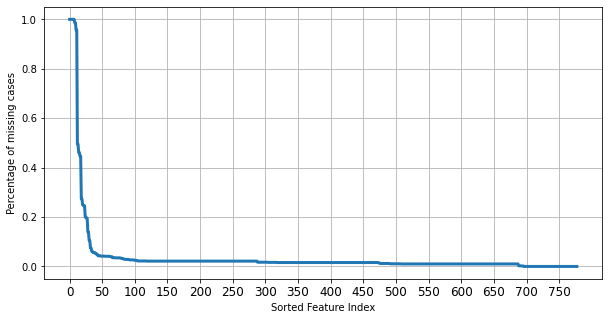

In [46]:
ds_missing = agg_feature.isnull().sum(axis=0)/len(agg_feature)
#thresholding
agg_feature_percent_missing  = agg_feature.loc[:,(ds_missing[ds_missing<.2]).index]
num_eliminated = agg_feature.shape[1]-agg_feature_percent_missing.shape[1]
num_total = agg_feature.shape[1]
print(f"{num_eliminated}/{num_total} features were missing more than 20\% of the time")

plt.figure(figsize=(10,5))
N, D = agg_feature.shape
ds_missing.sort_values(ascending=False).plot(linewidth=3)
I = np.arange(0,D,50)
plt.xticks(I,I, fontsize=12);
plt.grid()
plt.xlabel('Sorted Feature Index')
plt.ylabel('Percentage of missing cases')


##### varience thresholding

In [20]:
STD_cutoff_threshold = agg_feature_percent_missing.std().sort_values().iloc[280]

agg_feature_good_variance = agg_feature_percent_missing.iloc[
    :,agg_feature_percent_missing.std().values>STD_cutoff_threshold
]
agg_feature_good_variance.shape[1],'features kept ',agg_feature_percent_missing.shape[1]

(473, 'features kept ', 754)

In [ ]:

plt.figure(figsize=(10,5))
agg_feature_percent_missing.std().sort_values().plot(rot=60, linewidth=3)

plt.grid()
plt.ylabel('STD of the given feature')
plt.xlabel('Sorted Feature index')

I = np.arange(0,agg_feature_percent_missing.shape[1],40)
plt.xticks(I,I)

cutoff_threshold = 280
plt.plot([cutoff_threshold,cutoff_threshold],[0,.5],color='red', linewidth=5)
plt.text(200,0.25,'Cut off threshold')


##### Pairwise Correlation

###### prepare features order
- features highly correlated with target variable should come first in corr matrix


In [47]:
importance_order = pd.merge(
    labels_arm[['disturbance']],
    agg_feature_percent_missing
    ,left_index=True, right_index=True
).corr()['disturbance'].abs().sort_values(ascending=False).index.to_list()[1:]

Matrix = agg_feature_percent_missing[importance_order].corr()

Matrix

,ringer#SUP:RINGER_MODE_NORMAL|mean,data_RX2TX#MAX|std,battery_plugState#SUP:WIRELESS|std,battery_plugState#SUP:WIRELESS|mean,data_RX2TX#VAR|std,data_RX2TX#MAX|mean,data_RX2TX#VAR|mean,appUsage_appPackage#ETP|mean,screen#ASC|mean,appUsage_appPackage#ASC|mean,...,data_TX#SKW|std,bandDistance_pace#MIN|mean,accelerometer_Y#MIN|std,location_cluster#ETP|std,bandUV_indexLevel#SUP:MEDIUM|mean,bandUV_indexLevel#SUP:MEDIUM|std,bandAmbientLight_brightness#MINLAGVAL|mean,bandHeartRate_BPM#MINLAG|std,location_distance#BEP|mean,accelerometer_Z#SKW|std
ringer#SUP:RINGER_MODE_NORMAL|mean,1.00e+00,-9.59e-02,3.31e-01,3.72e-01,-0.08,-1.01e-01,-7.90e-02,-0.10,-1.28e-01,-0.15,...,1.28e-02,-2.09e-02,1.97e-02,-8.77e-02,-1.17e-02,-1.17e-02,-8.03e-04,8.65e-03,-1.84e-02,7.69e-02
data_RX2TX#MAX|std,-9.59e-02,1.00e+00,-3.42e-02,-2.78e-02,0.64,6.91e-01,5.11e-01,0.27,2.16e-01,0.23,...,3.20e-02,3.30e-02,2.64e-02,7.99e-02,-1.25e-02,-1.25e-02,-4.89e-02,-2.63e-03,-2.06e-02,8.12e-03
battery_plugState#SUP:WIRELESS|std,3.31e-01,-3.42e-02,1.00e+00,7.49e-01,-0.04,-4.57e-02,-3.96e-02,-0.02,-2.56e-02,-0.03,...,5.62e-02,4.78e-02,2.94e-02,3.08e-02,-3.85e-03,-3.83e-03,-1.81e-02,2.24e-02,1.33e-02,8.80e-02
battery_plugState#SUP:WIRELESS|mean,3.72e-01,-2.78e-02,7.49e-01,1.00e+00,-0.04,-4.85e-02,-3.74e-02,-0.07,-5.85e-02,-0.08,...,2.86e-02,5.38e-02,-1.03e-02,-2.00e-02,-3.70e-03,-3.68e-03,-1.84e-02,3.40e-03,3.79e-02,9.64e-02
data_RX2TX#VAR|std,-8.32e-02,6.43e-01,-4.16e-02,-3.88e-02,1.00,6.68e-01,9.07e-01,0.14,1.61e-01,0.11,...,-3.70e-02,4.81e-02,-2.26e-02,6.32e-02,-1.13e-02,-1.13e-02,-5.40e-02,-4.65e-02,-1.03e-02,-3.12e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bandUV_indexLevel#SUP:MEDIUM|std,-1.17e-02,-1.25e-02,-3.83e-03,-3.68e-03,-0.01,-1.64e-02,-1.11e-02,0.02,9.19e-02,0.04,...,-1.33e-02,-5.82e-03,-8.48e-03,6.24e-02,1.00e+00,1.00e+00,-2.58e-02,9.18e-03,-6.40e-02,-1.49e-02
bandAmbientLight_brightness#MINLAGVAL|mean,-8.03e-04,-4.89e-02,-1.81e-02,-1.84e-02,-0.05,-1.11e-02,-4.49e-02,0.03,1.83e-03,0.02,...,6.60e-03,-5.68e-02,-5.96e-02,-2.89e-02,-2.60e-02,-2.58e-02,1.00e+00,-3.11e-03,-2.26e-03,9.46e-02
bandHeartRate_BPM#MINLAG|std,8.65e-03,-2.63e-03,2.24e-02,3.40e-03,-0.05,-1.72e-03,-5.57e-02,0.09,1.32e-02,0.06,...,9.35e-03,-1.19e-01,2.65e-01,3.00e-03,9.19e-03,9.18e-03,-3.11e-03,1.00e+00,1.04e-02,5.68e-02
location_distance#BEP|mean,-1.84e-02,-2.06e-02,1.33e-02,3.79e-02,-0.01,8.71e-03,8.71e-04,-0.09,-2.00e-01,-0.15,...,-1.47e-02,-7.11e-03,2.32e-02,-3.47e-01,-6.36e-02,-6.40e-02,-2.26e-03,1.04e-02,1.00e+00,7.39e-02


In [50]:
top100_correlated_features = list(
    set(map(lambda x: x[:x.find('|')], importance_order[:100]))
)
top100_correlated_features

['wifi_numConnections#SKW',
 'screen#ASC',
 'battery_plugState#SUP:WIRELESS',
 'bandPedometer_step#LTI',
 'data_RX2TX#ASC',
 'data_RX2TX#LTI',
 'wifi_numConnections#AVG',
 'accelerometer_Y#SKW',
 'battery_temperature#MAXLAG',
 'ringer#SUP:RINGER_MODE_SILENT',
 'appUsage_appCategory#ASC',
 'bandDistance_pace#VAR',
 'wifi_numConnections#MAXLAGVAL',
 'bandPedometer_step#BEP',
 'appUsage_appPackage#ETP',
 'wifi_numConnections#MED',
 'accelerometer_Y#LTS',
 'wifi_numConnections#CID',
 'battery_plugState#SUP:AC',
 'bandDistance_pace#BEP',
 'battery_temperature#BEP',
 'bandPedometer_step#AVG',
 'wifi_numConnections#MIN',
 'bandDistance_speed#LTI',
 'screen#ETP',
 'data_TX#MAX',
 'data_RX2TX#MAX',
 'accelerometer_Z#LTI',
 'activity_event#ASC',
 'activity_event#SUP:WALKING',
 'wifi_numConnections#MAXLAG',
 'data_RX2TX#SKW',
 'unlock#SUP:UNLOCK',
 'bandGSR_resistance#MIN',
 'accelerometer_Y#MED',
 'bandDistance_speed#BEP',
 'bandAmbientLight_brightness#MED',
 'accelerometer_Y#MAX',
 'data_TX#CID

In [51]:
len(top100_correlated_features)

72

In [ ]:
pd.set_option("display.precision", 2)
matplotlib.rc('font', size=22)

import seaborn as sns
sns.heatmap(
    Matrix, cmap="YlGnBu",fmt='.2f' 
    ,annot=True, mask=np.triu(np.ones_like(Matrix))
)

In [24]:
import pandas
pd.set_option("display.precision", 2)
Matrix.style.background_gradient(cmap='coolwarm')

ImportError: Pandas requires version '2.11' or newer of 'jinja2' (version '2.10.1' currently installed).

###### selection with pairwise correlation
- find features to be eliminate
- store kept features

In [25]:
PAIRWISE_CORR_THRESHOLD = 0.8
eliminated_features = []
for r in range(Matrix.shape[0]):
    featurename = Matrix.index[r]   
    if str(featurename) in eliminated_features:
        continue
    pairwise_corr = Matrix.iloc[r,:r]
    eliminated_features+= pairwise_corr[
        pairwise_corr>PAIRWISE_CORR_THRESHOLD
    ].index.to_list()

kept_features_after_pairwise_correlation = list(
    set(Matrix.index.to_list()) - set(eliminated_features)
)
len(kept_features_after_pairwise_correlation)

394

###### fit classifier after eliminating multi colliniearity

In [26]:
data = pd.merge(
    labels_arm[['receptivity']],
    impute(
        agg_feature_percent_missing[kept_features_after_pairwise_correlation]
    )
    ,left_index=True, right_index=True
)

In [49]:
feature_selection={'status':False}
use_ray = False

measure = run_classification(
    #data.reset_index(), 
    data
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr'
    , classifier_name='lr'
)
measure.groupby(['CV_TYPE','experiment']).mean()

5it [00:00,  7.72it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr,56.55,56.42,61.22,0.57,76.14,75.82,78.98,0.83


In [ ]:
feature_selection={'status':False}
use_ray = False

measure = run_classification(
    data.reset_index(), 
    use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr'
    , classifier_name='lr'
)
measure.groupby(['CV_TYPE','experiment']).mean()

##### LogReg+Lasso 

In [50]:

from random import random


clf = LogisticRegression(penalty='l1', solver='saga', C=1, random_state=RANDOM_STATE)
clf.fit(
    data.drop(['receptivity'], axis=1)
    , data['receptivity']
)


/home/juma/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, penalty='l1', random_state=42, solver='saga')

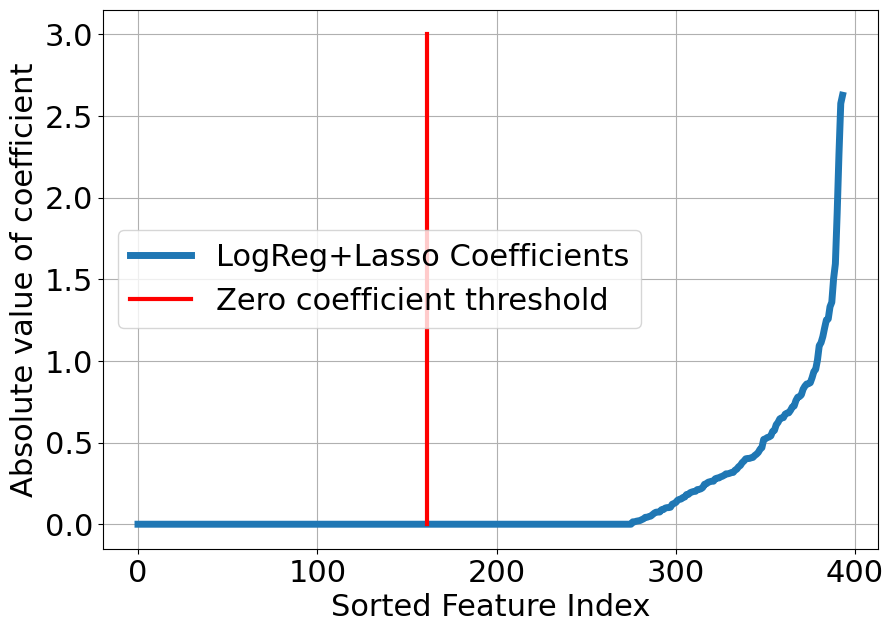

In [51]:
matplotlib.rc('font', size=22)

plt.figure(figsize=(10,7))
plt.grid()
plt.plot(np.sort(np.abs(clf.coef_[0])), linewidth=5, 
    label = 'LogReg+Lasso Coefficients'
)
plt.xlabel('Sorted Feature Index')
plt.ylabel("Absolute value of coefficient")

plt.plot(
    [161,161],[0,3], color='red', linewidth=3
    , label='Zero coefficient threshold'
)
plt.legend()


In [52]:
lasso_features = np.array(
    kept_features_after_pairwise_correlation
)[np.abs(clf.coef_[0])>0]
len(lasso_features)

128

###### test fit

In [53]:
feature_selection={'status':False}
use_ray = False

measure_catboost = run_classification(
    pd.merge(
        labels_arm[['receptivity']],
        impute(agg_feature_percent_missing[
            #kept_features_after_pairwise_correlation
            lasso_features
        ])
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr-after logreg-lasso'
    , classifier_name='lr'
)
measure_catboost.groupby(['CV_TYPE','experiment']).mean()

5it [00:00, 14.62it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-after logreg-lasso,60.78,60.33,64.45,0.63,73.06,72.72,76.18,0.81


In [ ]:
feature_selection={'status':False}
use_ray = False

measure_catboost = run_classification(
    pd.merge(
        labels_arm[['receptivity']],
        impute(agg_feature_good_variance[
            lasso_features
        ])
        ,left_index=True, right_index=True
    ).reset_index(), 
    use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='rf-after logreg-lasso'
    , classifier_name='rf'
)
measure_catboost.groupby(['CV_TYPE','experiment']).mean()

#### end of feature selection

In [54]:
len(lasso_features)

128

In [94]:
selected_features_agg = lasso_features
pd.DataFrame({
    'features':selected_features_agg
}).to_csv('selected_features_agg.csv',index=False)

In [96]:
selected_features = list(
    set(map(lambda x: x[:x.find('|')], selected_features_agg))
)

pd.DataFrame({
    'features':selected_features
}).to_csv('selected_features.csv',index=False)

print('features selected (mapped from agg. features):'
      ,len(selected_features))



features selected (mapped from agg. features): 105


### Mine Association Rules
- on RuleGenerateSet
- select sub featurs using RuleGenerate Set
- 

#### Feature selection
- extract sub features for the selected window size
- compute aggregated features
- exclude multicolliniear features
    - select aggregated features with correlation threshold of .06 

### map selected aggregated features to subfeatures

sub features selected (mapped from agg. features): 105


#### extract sliding features


In [21]:
ALREADY_EXTRACTED_SLIDINGFEATURES = True
selected_features = pd.read_csv('selected_features.csv')['features'].values

def prepare_sliding_features():
    import recept_dataset
    with on_ray(object_store_memory=2e10, ignore_reinit_error=True):    
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        sliding_features = recept_dataset.parallellize_extract_sliding(
                labels=labels_arm 
                , _sw_size_in_min = 20
                , selected_features=selected_features 
            )
    sliding_features.to_csv('feature/arm/sliding_features.csv')

if not ALREADY_EXTRACTED_SLIDINGFEATURES:
    prepare_sliding_features()

sliding_features = pd.read_csv(
    'feature/arm/sliding_features.csv'
    , dtype={'pid':'str'}
    , parse_dates=['timestamp']
).set_index(['pid','timestamp'])


sliding_features.isnull().sum().sort_values(ascending=False)     


bandCalory_burned#SKW             2559
ringer#ETP                        2159
ringer#ASC                        2159
bandHeartRate_BPM#ASC              708
bandHeartRate_BPM#MAX              708
                                  ... 
ringer#SUP:RINGER_MODE_VIBRATE       0
connection_type#SUP:WIFI             0
connection_status#SUP:False          0
activity_event#SUP:STILL             0
battery_plugState#SUP:WIRELESS       0
Length: 105, dtype: int64

In [23]:
sliding_features.shape

(9072, 105)

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(-20.0, 0, 'battery_temperature#LTS'),
  Text(0.0, 0, 'bandCalory_burned#SKW'),
  Text(20.0, 0, 'bandAmbientLight_brightness#AVG'),
  Text(40.0, 0, 'accelerometer_X#MINLAG'),
  Text(60.0, 0, 'data_RX2TX#MAX'),
  Text(80.0, 0, 'battery_temperature#MAXLAGVAL'),
  Text(100.0, 0, 'ringer#SUP:RINGER_MODE_VIBRATE'),
  Text(120.0, 0, '')])

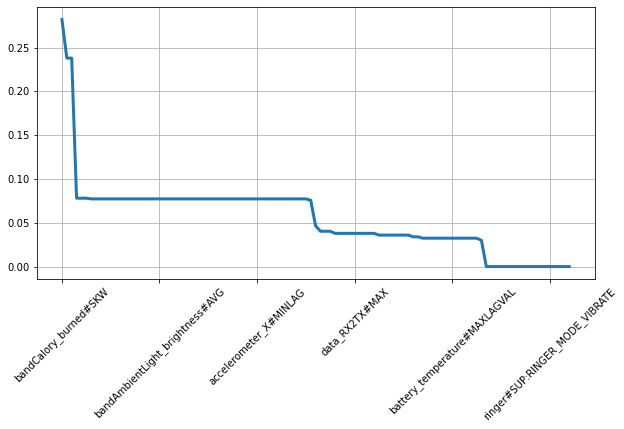

In [22]:
plt.figure(figsize=(10,5))

(sliding_features.isnull().sum(axis=0).sort_values(ascending=False)\
    /len(sliding_features)).plot(linewidth=3)
plt.grid(True)
plt.xticks(rotation=45, fontsize=10)

#### impute

In [24]:
imputed_sliding_features = impute(sliding_features)

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/juma/dataonssd/receptivity-1/analysis/f_preprocessing.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdata[c] = pdata[c].fillna(NAFILL)# there will still be some NaN values


#### Recode

In [35]:
pd.qcut(
    imputed_sliding_features.loc['1501','appUsage_appCategory#ASC']
    , q=3, labels=["l",'m','h']
)

timestamp
2019-05-16 10:20:00    l
2019-05-16 10:40:00    l
2019-05-16 11:00:00    l
2019-05-16 11:20:00    l
2019-05-16 11:40:00    l
                      ..
2019-05-22 20:40:00    l
2019-05-22 21:00:00    l
2019-05-22 21:20:00    m
2019-05-22 21:40:00    l
2019-05-22 22:00:00    l
Name: appUsage_appCategory#ASC, Length: 252, dtype: category
Categories (3, object): ['l' < 'm' < 'h']

In [2]:

    
from copy import deepcopy        
def discretize_df(data, cols, pid):
    df = deepcopy(data)
    count2 = 0
    count1 = 0
    count3 = 0
    for col in cols:
        try:
            df[col] = pd.qcut(df[col], 3, labels=["l","m","h"])
            count3 += 1
        except:
            try:
                df[col] = pd.qcut(df[col], 2, labels=["l","h"])
                count2 += 1
            except:
                df[col] = pd.qcut(df[col], 1, labels=["m"])
                count1 += 1
    #print(col, count1, count2, count3)
    df.insert(0,'pid',pid)
    df = df.reset_index().set_index(['pid']+data.index.names)
    return df


df_recoded = [] 
for pid in tqdm(imputed_sliding_features.index.get_level_values('pid').unique()):    
    print(f'pid = {pid}')
    res = discretize_df(imputed_sliding_features.loc[pid],
                        imputed_sliding_features.columns.tolist(), pid)
    df_recoded.append(res)
df_recoded = pd.concat(df_recoded)
df_recoded = df_recoded.astype('str').fillna('missing').astype('category')
df_recoded.head()

NameError: name 'tqdm' is not defined

### convert to transaction list

In [37]:
dataset = []
for i, r in df_recoded.iterrows():
    transaction = [f'{featurename}:{value}' 
                   for featurename, value in zip(r.index, r.values)]
    dataset.append(transaction)
len(dataset)
    

9072

#### mine Rules

In [38]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import (
    apriori, fpmax,fpgrowth, association_rules
)


te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
df


,accelerometer_X#CID:h,accelerometer_X#CID:l,accelerometer_X#CID:m,accelerometer_X#LTI:h,accelerometer_X#LTI:l,accelerometer_X#LTI:m,accelerometer_X#MINLAG:h,accelerometer_X#MINLAG:l,accelerometer_X#MINLAG:m,accelerometer_X#MINLAGVAL:h,...,wifi_numConnections#MAXLAGVAL:m,wifi_numConnections#MED:h,wifi_numConnections#MED:l,wifi_numConnections#MED:m,wifi_numConnections#MIN:h,wifi_numConnections#MIN:l,wifi_numConnections#MIN:m,wifi_numConnections#MINLAG:h,wifi_numConnections#MINLAG:l,wifi_numConnections#MINLAG:m
0,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
1,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
2,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
3,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
4,False,False,True,False,False,True,False,False,True,False,...,False,False,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9067,True,False,False,False,True,False,True,False,False,True,...,False,False,True,False,False,False,True,False,True,False
9068,False,False,True,False,True,False,True,False,False,False,...,True,False,True,False,False,True,False,False,True,False
9069,False,False,True,False,True,False,True,False,False,False,...,False,False,True,False,False,False,True,False,True,False
9070,False,False,True,True,False,False,False,True,False,False,...,True,False,True,False,False,True,False,False,True,False


In [39]:
frequent_itemsets = fpgrowth(
    df, min_support=0.3, use_colnames=True,
    max_len=5
)
### alternatively:
#frequent_itemsets = apriori(df, min_support=0.6, use_colnames=True)
#frequent_itemsets = fpmax(df, min_support=0.6, use_colnames=True)

frequent_itemsets

,support,itemsets
0,1.00,(bandUV_indexLevel#SUP:NONE:m)
1,1.00,(battery_status#SUP:FULL:m)
2,1.00,(appUsage_appCategory#SUP:Media/Entertainment:m)
3,1.00,(connection_type#SUP:WIFI:m)
4,1.00,(connection_type#SUP:MOBILE:m)
...,...,...
1946838,0.50,"(ringer#SUP:RINGER_MODE_VIBRATE:m, connection_..."
1946839,0.49,"(bandDistance_speed#MED:m, ringer#SUP:RINGER_M..."
1946840,0.47,"(ringer#SUP:RINGER_MODE_VIBRATE:m, battery_tem..."
1946841,0.47,"(ringer#SUP:RINGER_MODE_VIBRATE:m, bandDistanc..."


In [1]:
res = association_rules(
    frequent_itemsets, metric='confidence',  min_threshold=0.1
)
res

NameError: name 'association_rules' is not defined

### consequent length=1 filter

In [71]:
res=res.assign(
    consequent_length = res['consequents'].apply(lambda x: len(x))
    ,antecedant_length = res['antecedents'].apply(lambda x: len(x))
    , lift_log_scale_abs = np.log(res.lift)
)

# only keep the rules with consequent_length = 1
res = res[res.consequent_length==1]
res=res.assign(
    consequent = res['consequents'].apply(lambda x: list(x)[0][:-2])
)
res

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,consequent_length,antecedant_length,lift_log_scale_abs,consequent
0,(bandUV_indexLevel#SUP:NONE:m),(battery_status#SUP:FULL:m),1.00,1.00,1.00,1.00,1.00,0.00,inf,1,1,0.00,battery_status#SUP:FULL:m
1,(battery_status#SUP:FULL:m),(bandUV_indexLevel#SUP:NONE:m),1.00,1.00,1.00,1.00,1.00,0.00,inf,1,1,0.00,bandUV_indexLevel#SUP:NONE:m
2,(battery_status#SUP:FULL:m),(appUsage_appCategory#SUP:Media/Entertainment:m),1.00,1.00,1.00,1.00,1.00,0.00,inf,1,1,0.00,appUsage_appCategory#SUP:Media/Entertainment:m
3,(appUsage_appCategory#SUP:Media/Entertainment:m),(battery_status#SUP:FULL:m),1.00,1.00,1.00,1.00,1.00,0.00,inf,1,1,0.00,battery_status#SUP:FULL:m
4,(bandUV_indexLevel#SUP:NONE:m),(appUsage_appCategory#SUP:Media/Entertainment:m),1.00,1.00,1.00,1.00,1.00,0.00,inf,1,1,0.00,appUsage_appCategory#SUP:Media/Entertainment:m
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51911710,"(activity_event#SUP:STILL:m, bandCalory_burned...",(data_RX#MINLAG:m),0.61,0.83,0.47,0.77,0.93,-0.04,0.73,1,4,-0.08,data_RX#MINLAG:m
51911711,"(bandCalory_burned#MIN:m, data_RX#MINLAG:m, ri...",(activity_event#SUP:STILL:m),0.69,0.75,0.47,0.68,0.91,-0.05,0.78,1,4,-0.10,activity_event#SUP:STILL:m
51911712,"(activity_event#SUP:STILL:m, bandCalory_burned...",(battery_status#SUP:DISCHARGING:m),0.53,0.92,0.47,0.89,0.98,-0.01,0.79,1,4,-0.02,battery_status#SUP:DISCHARGING:m
51911713,"(activity_event#SUP:STILL:m, bandCalory_burned...",(ringer#SUP:RINGER_MODE_VIBRATE:m),0.50,0.94,0.47,0.94,1.00,0.00,1.00,1,4,0.00,ringer#SUP:RINGER_MODE_VIBRATE:m


In [73]:
res = res[res.consequent.isin(top100_correlated_features)]
res.shape

(0, 13)

In [67]:
count =0
for index in range(len(res)):
    print(index)
    if list(res['consequents'][index])[0][:-2] in top100_correlated_features:
        count+=1

0
1
2
3
4
5
6
7
8
9


KeyError: 9

In [42]:
topk_rules = pd.concat(
    [res.sort_values(['lift_log_scale_abs'],ascending=False)[:50]
    , res.sort_values(['lift_log_scale_abs'],ascending=False)[-50:]]
)
    
topk_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,consequent_length,antecedant_length,lift_log_scale_abs
12324100,"(ringer#ASC:m, bandCalory_burned#MINLAGVAL:l, ...",(bandCalory_burned#BEP:h),0.32,0.34,0.30,0.93,2.71,0.19,9.04,1,4,1.00
12324130,"(ringer#ETP:m, bandCalory_burned#MINLAGVAL:l, ...",(bandCalory_burned#BEP:h),0.32,0.34,0.30,0.93,2.71,0.19,9.04,1,4,1.00
12324070,"(powerEvent#ETP:m, bandCalory_burned#MINLAGVAL...",(bandCalory_burned#BEP:h),0.32,0.34,0.30,0.93,2.71,0.19,9.04,1,4,1.00
12323560,"(bandCalory_burned#MIN:m, bandCalory_burned#MI...",(bandCalory_burned#BEP:h),0.32,0.34,0.30,0.93,2.71,0.19,9.04,1,4,1.00
12323590,"(bandCalory_burned#MIN:m, bandCalory_burned#MI...",(bandCalory_burned#BEP:h),0.32,0.34,0.30,0.93,2.71,0.19,9.04,1,4,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
3197563,"(activity_event#SUP:STILL:m, ringer#SUP:RINGER...",(data_TX#MINLAG:m),0.69,0.69,0.42,0.60,0.86,-0.07,0.76,1,4,-0.15
3197714,"(activity_event#SUP:STILL:m, activity_event#SU...",(data_TX#MINLAG:m),0.69,0.69,0.42,0.60,0.86,-0.07,0.76,1,4,-0.15
3197953,"(activity_event#SUP:STILL:m, battery_status#SU...",(data_TX#MINLAG:m),0.69,0.69,0.42,0.60,0.86,-0.07,0.76,1,4,-0.15
3196964,"(activity_event#SUP:STILL:m, appUsage_appCateg...",(data_TX#MINLAG:m),0.69,0.69,0.42,0.60,0.86,-0.07,0.76,1,4,-0.15


In [43]:
topk_rules['antecedents'] = topk_rules['antecedents'].apply(lambda x: set(x))
topk_rules['consequents'] = topk_rules['consequents'].apply(lambda x: set(x))
topk_rules.to_csv('top100_rules.csv', index=False)

In [92]:
topk_rules_df = pd.read_csv('top100_rules.csv')
topk_rules_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,consequent_length,antecedant_length,lift_log_scale_abs
0,"{'bandCalory_burned#MINLAGVAL:l', 'ringer#SUP:...",{'bandCalory_burned#BEP:h'},0.32,0.34,0.30,0.93,2.71,0.19,9.04,1,4,1.00
1,"{'bandCalory_burned#MINLAGVAL:l', 'bandDistanc...",{'bandCalory_burned#BEP:h'},0.32,0.34,0.30,0.93,2.71,0.19,9.04,1,4,1.00
2,"{'bandCalory_burned#MINLAGVAL:l', 'bandDistanc...",{'bandCalory_burned#BEP:h'},0.32,0.34,0.30,0.93,2.71,0.19,9.04,1,4,1.00
3,"{'bandCalory_burned#MINLAGVAL:l', 'bandDistanc...",{'bandCalory_burned#BEP:h'},0.32,0.34,0.30,0.93,2.71,0.19,9.04,1,4,1.00
4,"{'bandCalory_burned#MINLAGVAL:l', 'battery_tem...",{'bandCalory_burned#BEP:h'},0.32,0.34,0.30,0.93,2.71,0.19,9.04,1,4,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"{'battery_status#SUP:FULL:m', 'activity_event#...",{'data_TX#MINLAG:m'},0.69,0.69,0.42,0.60,0.86,-0.07,0.76,1,4,-0.15
96,"{'connection_type#SUP:WIFI:m', 'activity_event...",{'data_TX#MINLAG:m'},0.69,0.69,0.42,0.60,0.86,-0.07,0.76,1,4,-0.15
97,"{'ringer#SUP:RINGER_MODE_NORMAL:m', 'appUsage_...",{'data_TX#MINLAG:m'},0.69,0.69,0.42,0.60,0.86,-0.07,0.76,1,4,-0.15
98,"{'connection_type#SUP:WIFI:m', 'activity_event...",{'data_TX#MINLAG:m'},0.69,0.69,0.42,0.60,0.86,-0.07,0.76,1,4,-0.15


# MLTrainEvalSet

In [63]:
selected_features = pd.read_csv('selected_features.csv')['features'].to_list()

In [64]:
selected_features

['bandHeartRate_RRInterval#LTI',
 'bandAmbientLight_brightness#BEP',
 'bandSkinTemperature_temperature#MINLAGVAL',
 'bandCalory_burned#MINLAG',
 'data_RX2TX#BEP',
 'bandCalory_burned#MIN',
 'accelerometer_Z#VAR',
 'bandDistance_speed#MED',
 'accelerometer_Z#MED',
 'battery_status#SUP:FULL',
 'battery_temperature#MAXLAG',
 'wifi_numConnections#LTS',
 'battery_temperature#BEP',
 'accelerometer_Y#LTS',
 'appUsage_appCategory#SUP:Finance',
 'activity_event#SUP:WALKING',
 'wifi_numConnections#MAX',
 'bandCalory_burned#MAXLAG',
 'bandPedometer_step#MINLAGVAL',
 'appUsage_appCategory#ASC',
 'activity_event#SUP:STILL',
 'bandDistance_speed#MAXLAGVAL',
 'location_distance#BEP',
 'bandAmbientLight_brightness#AVG',
 'bandHeartRate_RRInterval#ASC',
 'wifi_numConnections#MED',
 'accelerometer_Z#BEP',
 'wifi_numConnections#BEP',
 'accelerometer_Z#MINLAG',
 'wifi_numConnections#MIN',
 'bandDistance_pace#MIN',
 'bandDistance_speed#BEP',
 'bandAmbientLight_brightness#MINLAGVAL',
 'bandAmbientLight_brig

### Full features

#### Extract 

In [27]:
labels_ml

responseTime  responseTimestamp  \
pid  timestamp                                                           
3041 2019-05-01 10:30:08  2019-05-01 10:30:08+09:00      1556674208000   
     2019-05-01 11:26:31  2019-05-01 11:26:31+09:00      1556677591000   
     2019-05-01 13:00:57  2019-05-01 13:00:57+09:00      1556683257000   
     2019-05-01 14:31:22  2019-05-01 14:31:22+09:00      1556688682000   
     2019-05-01 15:11:33  2019-05-01 15:11:33+09:00      1556691093000   
...                                             ...                ...   
1511 2019-05-22 16:40:14  2019-05-22 16:40:14+09:00      1558510814000   
     2019-05-22 18:09:50  2019-05-22 18:09:50+09:00      1558516190000   
     2019-05-22 18:56:25  2019-05-22 18:56:25+09:00      1558518985000   
     2019-05-22 19:47:55  2019-05-22 19:47:55+09:00      1558522075000   
     2019-05-22 21:08:00  2019-05-22 21:08:00+09:00      1558526880000   

                                          scheduledTime  scheduledTimestamp  \
pid  timestamp                                                                
3041 2019-05-01 10:30:08  2019-05-01T10:28:00.000+09:00       1556674080000   
     2019-05-01 11:26:31  2019-05-01T11:26:00.000+09:00       1556677560000   
     2019-05-01 13:00:57  2019-05-01T12:59:00.000+09:00       1556683140000   
     2019-05-01 14:31:22  2019-05-01T14:29:00.000+09:00       1556688540000   
     2019-05-01 15:11:33  2019-05-01T15:10:00.000+09:00       1556691000000   
...                                                 ...                 ...   
1511 2019-05-22 16:40:14  2019-05-22T16:40:00.000+09:00       1558510800000   
     2019-05-22 18:09:50  2019-05-22T18:08:00.000+09:00       1558516080000   
     2019-05-22 18:56:25  2019-05-22T18:54:00.000+09:00       1558518840000   
     2019-05-22 19:47:55  2019-05-22T19:44:00.000+09:00       1558521840000   
     2019-05-22 21:08:00  2019-05-22T21:06:00.000+09:00       1558526760000   

                          valence  arousal  attention  stress  duration  \
pid  timestamp                                                            
3041 2019-05-01 10:30:08      3.0      2.0        2.0    -2.0       5.0   
     2019-05-01 11:26:31     -1.0     -2.0       -2.0     1.0       5.0   
     2019-05-01 13:00:57     -1.0     -3.0       -3.0     1.0      10.0   
     2019-05-01 14:31:22      2.0     -2.0        1.0    -1.0      20.0   
     2019-05-01 15:11:33     -1.0      1.0        3.0     2.0      10.0   
...                           ...      ...        ...     ...       ...   
1511 2019-05-22 16:40:14     -1.0     -1.0       -1.0     0.0      60.0   
     2019-05-22 18:09:50      2.0     -2.0       -3.0     0.0      15.0   
     2019-05-22 18:56:25      1.0      1.0        2.0     0.0      30.0   
     2019-05-22 19:47:55      1.0     -1.0        1.0    -1.0      20.0   
     2019-05-22 21:08:00      1.0      2.0        1.0     2.0      60.0   

                          disturbance  change  openness  conscientiousness  \
pid  timestamp                                                               
3041 2019-05-01 10:30:08          2.0     0.0      13.0                7.0   
     2019-05-01 11:26:31          2.0    -1.0      13.0                7.0   
     2019-05-01 13:00:57          1.0     0.0      13.0                7.0   
     2019-05-01 14:31:22          1.0     0.0      13.0                7.0   
     2019-05-01 15:11:33          2.0    -1.0      13.0                7.0   
...                               ...     ...       ...                ...   
1511 2019-05-22 16:40:14          3.0     0.0      12.0               11.0   
     2019-05-22 18:09:50          2.0     0.0      12.0               11.0   
     2019-05-22 18:56:25          2.0     0.0      12.0               11.0   
     2019-05-22 19:47:55         -1.0     0.0      12.0               11.0   
     2019-05-22 21:08:00          1.0     0.0      12.0               11.0   

                          neuroticism  extraversion  agre

In [72]:

    
full_features = recept_dataset.parallellize_extract(
    labels=labels_ml, 
    w_size_in_min=80,
    selected_features=selected_features
    , use_ray =True
    )
    

  0%|          | 0/37 [00:00<?, ?it/s](extract pid=278941) E0831 08:58:57.416473547  278941 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(extract pid=278901) E0831 08:58:57.419249606  278901 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(extract pid=278906) E0831 08:58:57.417407484  278906 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(extract pid=278909) E0831 08:58:57.430581811  278909 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(extract pid=278936) E0831 08:58:57.414679603  278936 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(extract pid=278943) E0831 08:58:57.426494043  278943 chttp2_transport.cc:1103]   Recei

(extract pid=278900) preprocessing 3029
(extract pid=278890) preprocessing 1506
(extract pid=278942) preprocessing 1502
(extract pid=278918) preprocessing 714
(extract pid=278882) preprocessing 726
(extract pid=278886) preprocessing 1514
(extract pid=278915) preprocessing 1511
(extract pid=278935) preprocessing 3018
(extract pid=278938) preprocessing 1509
(extract pid=278930) preprocessing 709
(extract pid=278945) preprocessing 1541
(extract pid=278948) preprocessing 710
(extract pid=278946) preprocessing 1507
(extract pid=278924) preprocessing 1522
(extract pid=278940) preprocessing 707
(extract pid=278902) preprocessing 721
(extract pid=278892) preprocessing 1504
(extract pid=278903) preprocessing 1517
(extract pid=278897) preprocessing 3009
(extract pid=278913) preprocessing 3025
(extract pid=278949) preprocessing 1505
(extract pid=278899) preprocessing 713
(extract pid=278917) preprocessing 1519
(extract pid=278894) preprocessing 702
(extract pid=278896) preprocessing 1527
(extract

  3%|▎         | 1/37 [00:58<34:52, 58.12s/it]

(extract pid=278882) preprocessing 726 done


  8%|▊         | 3/37 [01:02<08:08, 14.36s/it]

(extract pid=278945) preprocessing 1541 done


 11%|█         | 4/37 [01:04<05:18,  9.64s/it]

(extract pid=278900) preprocessing 3029 done
(extract pid=278906) preprocessing 708 done
(extract pid=278921) preprocessing 706 done
(extract pid=278890) preprocessing 1506 done


 14%|█▎        | 5/37 [01:16<05:32, 10.38s/it]

(extract pid=278928) preprocessing 1518 done


 27%|██▋       | 10/37 [01:22<01:16,  2.84s/it]

(extract pid=278911) preprocessing 3022 done
(extract pid=278941) preprocessing 719 done
(extract pid=278904) preprocessing 3023 done


 35%|███▌      | 13/37 [01:31<00:59,  2.47s/it]

(extract pid=278940) preprocessing 707 done
(extract pid=278949) preprocessing 1505 done
(extract pid=278934) preprocessing 3041 done
(extract pid=278942) preprocessing 1502 done


 43%|████▎     | 16/37 [01:38<00:43,  2.09s/it]

(extract pid=278894) preprocessing 702 done
(extract pid=278886) preprocessing 1514 done


 51%|█████▏    | 19/37 [01:45<00:35,  1.97s/it]

(extract pid=278892) preprocessing 1504 done
(extract pid=278925) preprocessing 1503 done
(extract pid=278896) preprocessing 1527 done
(extract pid=278938) preprocessing 1509 done
(extract pid=278901) preprocessing 712 done
(extract pid=278943) preprocessing 3030 done


 54%|█████▍    | 20/37 [01:50<00:49,  2.90s/it]

(extract pid=278930) preprocessing 709 done
(extract pid=278899) preprocessing 713 done


 62%|██████▏   | 23/37 [01:51<00:20,  1.45s/it]

(extract pid=278946) preprocessing 1507 done
(extract pid=278909) preprocessing 724 done
(extract pid=278918) preprocessing 714 done


 70%|███████   | 26/37 [01:54<00:12,  1.13s/it]

(extract pid=278936) preprocessing 3010 done
(extract pid=278948) preprocessing 710 done


 73%|███████▎  | 27/37 [01:55<00:11,  1.12s/it]

(extract pid=278924) preprocessing 1522 done
(extract pid=278913) preprocessing 3025 done


 78%|███████▊  | 29/37 [01:56<00:06,  1.21it/s]

(extract pid=278935) preprocessing 3018 done
(extract pid=278902) preprocessing 721 done


 97%|█████████▋| 36/37 [02:02<00:00,  1.09it/s]

(extract pid=278915) preprocessing 1511 done


100%|██████████| 37/37 [02:07<00:00,  3.43s/it]


In [73]:
full_features

appUsage_appCategory#ASC  \
pid  timestamp                                       
3041 2019-05-01 10:30:08                      98.0   
     2019-05-01 11:26:31                      87.0   
     2019-05-01 13:00:57                      68.0   
     2019-05-01 14:31:22                      27.0   
     2019-05-01 15:11:33                      42.0   
...                                            ...   
1511 2019-05-22 16:40:14                      46.0   
     2019-05-22 18:09:50                      74.0   
     2019-05-22 18:56:25                      79.0   
     2019-05-22 19:47:55                     106.0   
     2019-05-22 21:08:00                      12.0   

                          appUsage_appCategory#SUP:Finance  \
pid  timestamp                                               
3041 2019-05-01 10:30:08                             124.0   
     2019-05-01 11:26:31                             403.0   
     2019-05-01 13:00:57                             333.0   
     2019-05-01 14:31:22                               0.0   
     2019-05-01 15:11:33                               0.0   
...                                                    ...   
1511 2019-05-22 16:40:14                               2.0   
     2019-05-22 18:09:50                              11.0   
     2019-05-22 18:56:25                               7.0   
     2019-05-22 19:47:55                               0.0   
     2019-05-22 21:08:00                               0.0   

                          appUsage_appCategory#SUP:Social/Communication  \
pid  timestamp                                                            
3041 2019-05-01 10:30:08                                         1897.0   
     2019-05-01 11:26:31                                         2622.0   
     2019-05-01 13:00:57                                         1187.0   
     2019-05-01 14:31:22                                         1008.0   
     2019-05-01 15:11:33                                         2654.0   
...                                                                 ...   
1511 2019-05-22 16:40:14                                          929.0   
     2019-05-22 18:09:50                                          458.0   
     2019-05-22 18:56:25                                          744.0   
     2019-05-22 19:47:55                                          705.0   
     2019-05-22 21:08:00                                           70.0   

                          appUsage_appCategory#SUP:Tools  \
pid  timestamp                                             
3041 2019-05-01 10:30:08                          1321.0   
     2019-05-01 11:26:31                           619.0   
     2019-05-01 13:00:57                           390.0   
     2019-05-01 14:31:22                           262.0   
     2019-05-01 15:11:33                           330.0   
...                                                  ...   
1511 2019-05-22 16:40:14                          1599.0   
     2019-05-22 18:09:50                          1219.0   
     2019-05-22 18:56:25                          1350.0   
     2019-05-22 19:47:55                           685.0   
     2019-05-22 21:08:00                           456.0   

                          battery_temperature#MAX  battery_temperature#BEP  \
pid  timestamp                                                               
3041 2019-05-01 10:30:08                29.100000                 1.358014   
     2019-05-01 11:26:31                34.100000                 2.156914   
     2019-05-01 13:00:57                34.645024                 2.116886   
     2019-05-01 14:31:22                34.800000                 2.020207   
     2019-05-01 15:11:33                35.800000                 1.927601   
...                                           ...                      ...   
1511 2019-05-22 16:40:14                34.400000                 1.775716   
     2019-05-22 18:09:50                34.600000        

In [74]:
feature_selection={'status':False}
use_ray = False

measure_catboost = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        impute(full_features)
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr-after logreg-lasso'
    , classifier_name='lr'
)
measure_catboost.groupby(['CV_TYPE','experiment']).mean()

/datadrive/receptivity/analysis/feature_preprocessing.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdata.loc[:,c] = pdata[c].fillna(pdata[c].mean())
/datadrive/receptivity/analysis/feature_preprocessing.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdata.loc[:,c] = pdata[c].fillna(pdata[c].mean())
/datadrive/receptivity/analysis/feature_preprocessing.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-after logreg-lasso,54.317764,53.07719,56.575201,0.562232,64.281892,64.300659,67.708743,0.701003


#### Classification

In [ ]:

data = pd.merge(labels_ml[['is_opportune_moment']], full_features_ml, left_index=True, right_index=True )

measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()

- using reduced ML set

In [ ]:


data = pd.merge(labels_ml[['is_opportune_moment']], full_features_ml, left_index=True, right_index=True )
data = pd.merge(data, featuresCFF[[]],left_index=True, right_index=True)# to reduce
measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()


### Agg 

#### extract sub features
- extract sub features only for selected 


In [ ]:
selected_features_mapped[:3]

In [ ]:
ml_sub_features_d={}
windows = {
    '6HR': 6*60 * 60,
}

with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=35):    
    for window_name, window_size  in windows.items():
        ml_sub_features_d[window_name] = dataset.parallellize_extract_sub(
            labels=labels_ml, 
            w_name=window_name,
            w_size = window_size,
            selected_features=selected_features_mapped,
            use_ray=True            
        )

        
    

In [ ]:
df_sub_ml = ml_sub_features_d['6HR']
df_sub_ml.to_csv(f'features/ml-sub-window_6HR-numSub_12_FS.csv')
df_sub_ml = pd.read_csv(f'features/ml-sub-window_6HR-numSub_12_FS.csv', dtype={'pid':'str'},
                     parse_dates=['timestamp'])
df_sub_ml.set_index(['pid','timestamp','sub_timestamp'], inplace=True)

df_sub_ml

#### impute

In [ ]:

df_sub_ml = impute_by_filling_support_features(df_sub_ml)
df_sub_ml.iloc[:,df_sub_ml.columns.str.contains('SUP')].std().sum()

In [ ]:
df_sub_ml = impute_with_mean_of_participant(df_sub_ml)
df_sub_ml.shape

In [ ]:
agg_feature_ml = df_sub_ml.groupby(['pid','timestamp']).agg(['mean','std'])
agg_feature_ml.columns = agg_feature_ml.columns.map('|'.join).str.strip('|')
agg_feature_ml = drop_zero_varience_features(agg_feature_ml)

In [ ]:
agg_feature_ml

#### Classification performance

In [ ]:

data = pd.merge(labels_ml[['is_opportune_moment']], agg_feature_ml, left_index=True, right_index=True )

measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()

- reduced set

In [ ]:
data = pd.merge(labels_ml[['is_opportune_moment']], agg_feature_ml, left_index=True, right_index=True )
data = pd.merge(data, featuresCFF[[]],left_index=True, right_index=True)# to reduce
measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()

### CFF
- impute
- recode

In [ ]:
df_sub_ml = pd.read_csv(f'features/ml-sub-window_6HR-numSub_12_FS.csv', dtype={'pid':'str'},
                     parse_dates=['timestamp'])
df_sub_ml.set_index(['pid','timestamp','sub_timestamp'], inplace=True)


df_sub_ml = impute_by_filling_support_features(df_sub_ml)

df_sub_ml.isnull().sum(axis=0).sort_values(ascending=False)

#### recode

In [ ]:
df_sub_ml_recoded = [] 
for pid in tqdm(df_sub_ml.index.get_level_values('pid').unique()):    
    res = discretize_df(df_sub_ml.loc[pid],df_sub_ml.columns.tolist(), pid)
    
    df_sub_ml_recoded.append(res)
    
df_sub_ml_recoded = pd.concat(df_sub_ml_recoded)
df_sub_ml_recoded = df_sub_ml_recoded.reset_index().set_index(['pid', 'timestamp','sub_timestamp'])
df_sub_ml_recoded = df_sub_ml_recoded.astype('object').fillna('missing').astype('category')

In [ ]:
df_sub_ml_recoded.shape

#### extract 

- for each rule
  - select the df that satisfy the context
     - extract Y from contextually filtered subfeatures and add to features


In [ ]:
TOPK_RULES = 40
rules_df = pd.read_csv('rules/rules1000-mlen_10.csv', usecols=['rules','lift'], dtype={'lift':float})
rules_df = rules_df.iloc[:TOPK_RULES]
rules_df = rules_df[rules_df.lift>1.05]

#rules_df.rules = rules_df.rules.str.replace('.SUP.','.SUP:').str.replace('.','#')
featuresCFF = pd.DataFrame()# we store CFF here


for i,rule in (rules_df.iterrows()):
    context, y = rule['rules'].split(' => ')
    
    #clean `{`
    context = context[1:-1]    
    y = y[1:-1]
    
    #'BND_DST_PAC#3HR#30MIN#VAR=m' =>'BND_DST_PAC#3HR#30MIN#VAR'
    y=y.split('=')[0]    
    
    # flag the indices that satisfy our context
    index_flag = True
    for c in context.split(','): #'BND_DST_PAC#3HR#30MIN#VAR=m', 'BND_DST_SPD#3HR#30MIN#BEP=m'
        name, val = c.split('=')
        index_flag = index_flag & (df_sub_ml_recoded[name]==val)        
    featuresCFF[f'mean-{y}-context_{context}'] = df_sub_ml[index_flag][y].groupby(['pid','timestamp']).mean()
    featuresCFF[f'std-{y}-context_{context}'] = df_sub_ml[index_flag][y].groupby(['pid','timestamp']).std()
    

In [ ]:
featuresCFF.shape # topK =400 rules

In [ ]:
features.head()

In [ ]:
featuresCFF = impute_with_mean_of_participant(featuresCFF)


#### Classifier Performance

In [ ]:
data = pd.merge(labels_ml[['is_opportune_moment']], featuresCFF, left_index=True, right_index=True )
data

In [ ]:

data = pd.merge(labels_ml[['is_opportune_moment']], features, left_index=True, right_index=True )

measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()

### Combining

In [ ]:
full_features_ml.shape

In [ ]:
featuresCFF.shape

In [ ]:
agg_feature_ml.shape

In [ ]:
data = pd.merge(full_features_ml, featuresCFF, left_index=True, right_index=True )
data = pd.merge(data, agg_feature_ml, left_index=True, right_index=True )
data = pd.merge(labels_ml[['is_opportune_moment']], data, left_index=True, right_index=True )
data

In [ ]:
measure = run_classification(data.reset_index())
measure.groupby('CV_TYPE').mean()